# Investigating Classical-optimizers on solving MAXCUT

There are several optimzers to pickfrom 

#### Non-Gradient
- Nelder Mead
- SPSA
- SQPLSA
- LM-BFGS

####  Gradient Based
- ADAM
- Gradient Descent


In [11]:
node_size = 6
n_layers = 1
graph_type = "Uniform Random"

In [12]:
import os
import logging
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import argparse
import time
import mlflow
import json
import pandas as pd
from qiskit import Aer
from qiskit.algorithms.optimizers import ADAM, COBYLA, NELDER_MEAD, SPSA, L_BFGS_B, GradientDescent
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut

# Custom imports
from haqc.generators.graph_instance import create_graphs_from_all_sources
from haqc.exp_utils import (
    str2bool,
    to_snake_case,
    make_temp_directory,
    check_boto3_credentials,
)
from haqc.features.graph_features import get_graph_features
from haqc.generators.parameter import get_optimal_parameters
from haqc.solutions.solutions import compute_max_cut_brute_force, compute_distance
from haqc.parallel.landscape_parallel import parallel_computation
from haqc.initialisation.initialisation import Initialisation
from haqc.plot.utils import *
from haqc.initialisation.parameter_fixing import get_optimal_parameters_from_parameter_fixing

# Logger setup
logging.basicConfig(
    level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s'
)
qiskit_logger = logging.getLogger('qiskit')
qiskit_logger.setLevel(logging.ERROR)  # or use logging.CRITICAL
logging.info('Script started')


2024-02-04 11:22:58,556 - INFO - Script started


In [13]:
# Check that optimal parameters csv file exists
if not os.path.exists('../data/optimal-parameters.csv'):
    raise FileNotFoundError('Optimal parameters csv file not found.')

# Load the optimal parameters DataFrame from the csv file
df = pd.read_csv('../data/optimal-parameters.csv')
df.head()

,Source,params.n_layers,median_beta_1,median_gamma_1,median_beta_2,median_gamma_2,median_beta_3,median_gamma_3,median_beta_4,median_gamma_4,median_beta_5,median_gamma_5
0,four_regular_graph,1,-0.298606,-0.455742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,geometric,1,0.218053,-0.229041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nearly_complete_bi_partite,1,-0.336615,0.410319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,power_law_tree,1,0.392695,0.789341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,three_regular_graph,1,0.260689,-0.570326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Generate all graph sources
G_instances = create_graphs_from_all_sources(instance_size=node_size, sources="ALL")
G_instances = [g for g in G_instances if g.graph_type == graph_type]
graph_instance = G_instances[0]
G = graph_instance.G

print(
    f"\n{'-'*10} This run is for a {graph_instance.graph_type} graph with {len(G.nodes())} nodes  {'-'*10}\n"
)

Guess 1 for producing a connected Geometric Graph with r=1.0894487338694059 - connected: True

---------- This run is for a Uniform Random graph with 6 nodes  ----------



In [15]:
# Show instance features
graph_features = get_graph_features(graph_instance.G)
instance_class = to_snake_case(graph_instance.graph_type)
graph_features = {str(key): val for key, val in graph_features.items()}
print(f"Graph Features {json.dumps(graph_features, indent=2)}")

Graph Features {
  "acyclic": false,
  "algebraic_connectivity": 0.0,
  "average_distance": 1.1666666666666665,
  "bipartite": false,
  "clique_number": 3,
  "connected": false,
  "density": 0.3333333333333333,
  "diameter": 0,
  "edge_connectivity": 0,
  "eulerian": false,
  "laplacian_largest_eigenvalue": 3.0,
  "maximum_degree": 2,
  "minimum_degree": 1,
  "minimum_dominating_set": 2,
  "number_of_components": 2,
  "number_of_edges": 5,
  "number_of_vertices": 6,
  "planar": true,
  "radius": 0,
  "regular": false,
  "laplacian_second_largest_eigenvalue": 3.073730366968243e-16,
  "ratio_of_two_largest_laplacian_eigenvaleus": 9760127408179376.0,
  "smallest_eigenvalue": -2.0175153220989226e-16,
  "vertex_connectivity": 0,
  "number_of_cut_vertices": 1,
  "number_of_minimal_odd_cycles": 1,
  "group_size": 12.0,
  "number_of_orbits": 3,
  "is_distance_regular": false
}


<class 'networkx.utils.decorators.argmap'> compilation 48:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [16]:
# Generate the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G)
max_cut = Maxcut(adjacency_matrix)
qubitOp, offset = max_cut.to_quadratic_program().to_ising()

# Brute Force Solution for Max-Cut Problem
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")
max_cut_partition, max_cut_value = compute_max_cut_brute_force(G)
print(f"MAXCUT Paritition: {max_cut_partition}")
print(f"MAXCUT Value: {max_cut_value}")


---------- Solving for Exact Ground State ----------

MAXCUT Paritition: (0, 1)
MAXCUT Value: 4


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_38257/2359658765.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)


In [17]:
# Visualization code here...
print(f"\n{'-'*10} Solving for Exact Ground State {'-'*10}\n")
exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator=qubitOp)
print(f"Minimum Energy is {exact_result}")


---------- Solving for Exact Ground State ----------

Minimum Energy is {   'aux_operator_eigenvalues': None,
    'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2)), coeff=1.0, is_measurement=False),
    'eigenvalue': (-1.5+0j)}


In [28]:
N_LAYERS = n_layers
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend)

# Define optimizers
algos_optimizers = [
    ('QAOA', 'COBYLA', COBYLA()),
    ('QAOA', 'ADAM', ADAM()),
    ('QAOA', 'NELDER_MEAD', NELDER_MEAD()),
    ('QAOA', 'SPSA', SPSA(maxiter=1000, blocking=True, learning_rate=0.01, perturbation=0.001, second_order=True)),
    ('QAOA', 'L_BFGS_B', L_BFGS_B()),
    ('QAOA', 'GradientDescent', GradientDescent())
]

In [29]:
# Use QAOA with Instance Based Initialization
init_type = 'QIBPI'
# Get instance optimised paramters
optimal_params = get_optimal_parameters(instance_class, n_layers, df)
# Check if optimal parameters were found
if isinstance(optimal_params, str):
    logging.warning(optimal_params)
else:
    optimal_beta = np.array(optimal_params['beta'])
    optimal_gamma = np.array(optimal_params['gamma'])
    initial_point_optimal = np.concatenate([optimal_beta, optimal_gamma])
    initial_point = initial_point_optimal

In [30]:
results_df = pd.DataFrame(
    columns=['algo', 'init_type', 'eval_count', 'parameters', 'energy', 'std']
)

for algo_name, optimizer_name, optimizer in algos_optimizers:
    logging.info(f"Running {algo_name} with {optimizer_name} Initialization")

    # Print initial values from algorithm
    logging.info(f"Initial point ({algo_name} - {optimizer_name}): {initial_point}")

    # Callback function to store intermediate values
    intermediate_values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        if eval_count % 100 == 0:
            logging.info(
                f"{type(optimizer).__name__} iteration {eval_count} \t cost function {mean}"
            )
        betas = parameters[:N_LAYERS]  # Extracting beta values
        gammas = parameters[N_LAYERS:]  # Extracting gamma values
        intermediate_values.append(
            {
                'eval_count': eval_count,
                'parameters': {'gammas': gammas, 'betas': betas},
                'mean': mean,
                'std': std,
            }
        )

    # Use optimizer algorithm based on its name (e.g., COBYLA)
    if algo_name == 'QAOA':
        qaoa = QAOA(
            optimizer=optimizer,
            reps=N_LAYERS,
            initial_point=initial_point,
            callback=store_intermediate_result,
            quantum_instance=quantum_instance,
            include_custom=True,
        )
        algo_result = qaoa.compute_minimum_eigenvalue(qubitOp)
    else:
        # Add optimizer= for other algorithms here (could start off with VQE here too)
        pass
    # Compute performance metrics
    eval_counts = [
        intermediate_result['eval_count']
        for intermediate_result in intermediate_values
    ]

    most_likely_solution = max_cut.sample_most_likely(algo_result.eigenstate)
    # Calculate the energy gap
    energy_gap = exact_result.eigenvalue.real - algo_result.eigenvalue.real

    # Convert exact result eigenstate to matrix form and get QAOA state
    exact_result_vector = exact_result.eigenstate.to_matrix()
    qaoa_state_vector = algo_result.eigenstate

    # Compute inner product between exact result and QAOA state
    inner_product = np.dot(exact_result_vector.conj(), qaoa_state_vector)

    # Calculate the probability of success (adjusting for MAXCUT symmetry)
    success_probability = (np.abs(inner_product) ** 2) * 2

    # Calculate the approximation ratio
    approximation_ratio = algo_result.eigenvalue.real / exact_result.eigenvalue.real

    # Calculate Distance
    distance = compute_distance(
        N_LAYERS,
        initial_point[:N_LAYERS],
        algo_result.optimal_point[:N_LAYERS],
        initial_point[N_LAYERS:],
        algo_result.optimal_point[N_LAYERS:],
    )
    logging.info(f"Distance between initial point and optimal point: {distance}")

    # Compile results into a dataframe from intermediate values
    results_df = results_df.append(
        pd.DataFrame(
            {
                'algo': [algo_name] * len(intermediate_values),
                'optimizer_name': [optimizer_name] * len(intermediate_values),
                'eval_count': [
                    intermediate_result['eval_count']
                    for intermediate_result in intermediate_values
                ],
                'parameters': [
                    intermediate_result['parameters']
                    for intermediate_result in intermediate_values
                ],
                'energy': [
                    intermediate_result['mean']
                    for intermediate_result in intermediate_values
                ],
                'std': [
                    intermediate_result['std']
                    for intermediate_result in intermediate_values
                ],
            }
        )
    )

2024-02-04 11:32:10,000 - INFO - Running QAOA with COBYLA Initialization
2024-02-04 11:32:10,001 - INFO - Initial point (QAOA - COBYLA): [-0.27800927  0.37498212]
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/vivekkatial/Library/Caches/pypoetry/virtualenvs/haqc-RI3cX6zS-py3.8/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: 

In [31]:
results_df['init_type'] = "QIBPI"
results_df.head()

,algo,init_type,eval_count,parameters,energy,std,optimizer_name
0,QAOA,QIBPI,1,"{'gammas': [0.3749821186472228], 'betas': [-0....",-0.719274,0.0,COBYLA
1,QAOA,QIBPI,2,"{'gammas': [0.3749821186472228], 'betas': [0.7...",0.414976,0.0,COBYLA
2,QAOA,QIBPI,3,"{'gammas': [1.3749821186472229], 'betas': [-0....",-0.379908,0.0,COBYLA
3,QAOA,QIBPI,4,"{'gammas': [0.08833879516643478], 'betas': [-1...",0.218488,0.0,COBYLA
4,QAOA,QIBPI,5,"{'gammas': [0.2316604569068288], 'betas': [-0....",0.015208,0.0,COBYLA


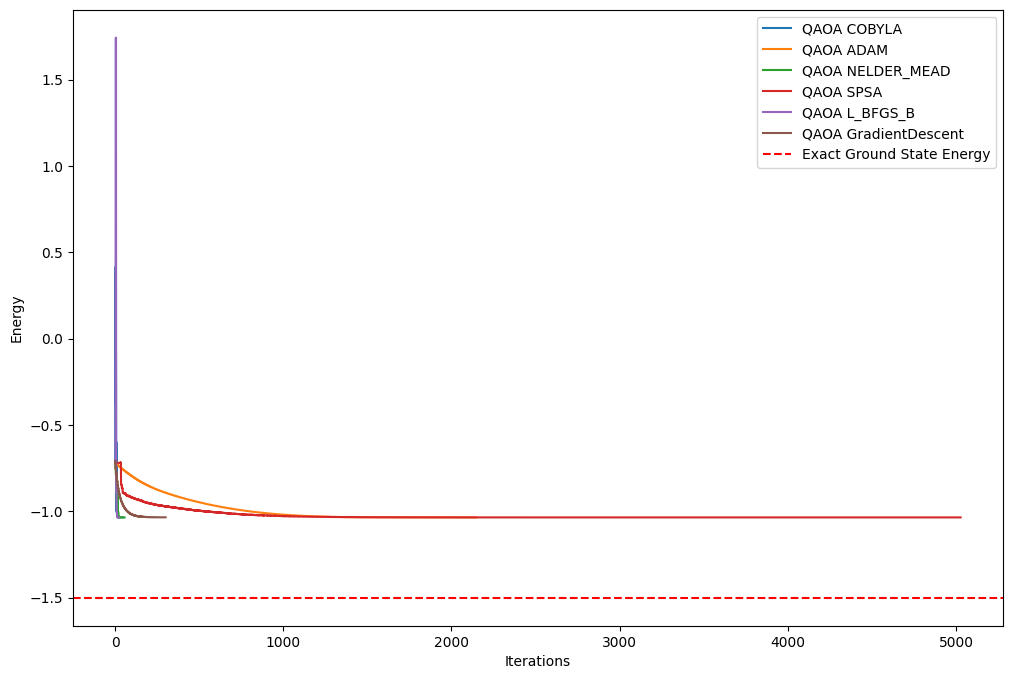

In [32]:
# Plot energy vs iterations for each algorithm and initialization on a single chart
plt.figure(figsize=(12, 8))
for algo_name, optimizer_name, optimizer in algos_optimizers:
    # Filter results for specific algorithm and initialization
    filtered_results_df = results_df[
        (results_df['algo'] == algo_name)
        & (results_df['optimizer_name'] == optimizer_name)
    ]
    # Plot energy vs iterations
    plt.plot(
        filtered_results_df['eval_count'],
        filtered_results_df['energy'],
        label=f"{algo_name} {optimizer_name}",
    )
    
plt.axhline(
        y=exact_result.eigenvalue.real,
        color='r',
        linestyle='--',
        label='Exact Ground State Energy',
    )

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()


In [ ]:
plt.clf()